In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import vegas as vg
import gvar as gv
import random
from scipy import interpolate
import scipy.stats
from scipy.integrate import quad

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.pyplot import *
from matplotlib.legend_handler import HandlerLine2D

In [2]:
fsize = 12

rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['computer modern roman', 'serif']
# rcParams['figure.figsize'] = (1.2*3.7,1.2*2.3617)
rcParams['hatch.linewidth'] = 0.3
rcParams['axes.labelsize'] = fsize
rcParams['xtick.labelsize'] = fsize
rcParams['ytick.labelsize'] = fsize
rcParams['axes.titlesize'] = 10
rcParams['legend.frameon'] = False
rcParams['legend.fontsize'] = 0.8*fsize
rcParams['legend.loc'] = 'best'

In [3]:
from dark_news import *

In [4]:
save_folder = (f'./fig/3_flux_xsec_plot/')
!mkdir -p $save_folder

In [5]:
heavy_bp = {
        'm4':0.1,
        'mz':1.25,
        'alpha_dark':0.4,
        'epsilon':np.sqrt(4.6e-4),
        'Umu4_2':2.2e-7,
        'Ud4_2':1,
    }

In [6]:
BSMparams = model.model_params()

BSMparams.Ue4 = 0.0
BSMparams.Umu4 = np.sqrt(heavy_bp['Umu4_2'])
BSMparams.Utau4 = 0.0
BSMparams.Ue5 = 0.0
BSMparams.Umu5 = 0.0
BSMparams.Utau5 = 0.0
BSMparams.Ue6 = 0.0
BSMparams.Umu6 = 0.0
BSMparams.Utau6 = 0.0
BSMparams.UD4 = np.sqrt(heavy_bp['Ud4_2'])
BSMparams.UD5 = 0.0
BSMparams.UD6 = 0.0
BSMparams.m4 = heavy_bp['m4']
BSMparams.m5 = 1e6
BSMparams.m6 = 1e6
BSMparams.Mzprime = heavy_bp['mz']
BSMparams.D_or_M = 'majorana'
BSMparams.epsilon = heavy_bp['epsilon']

### fluxes

In [8]:
# material_mass_t2k = {'hydrogen': 0.5507270215029775,
#                  'carbon': 9.722023965952,
#                  'oxygen': 3.420920851265022,
#                  'copper': 0.8679,
#                  'zinc': 0.4471,
#                  'lead': 3.634,
#                  'argon': 0.01602}

material_mass_t2k = {
                     # 'hydrogen': 1.5564074589846346,
                     'oxygen': 2.7123832709262223,
                     'carbon': 8.083881108809143,
                     'copper': 1.6500000000000001,
                     'zinc': 0.8499999999999999,
                     'lead': 3.108,
                     'argon': 0.01602}

material_mass_mb = {
                    # 'hydrogen': 818*2/14,
                    'carbon': 818*12/14,}

material_A = {'hydrogen': 1,
              'carbon': 12,
              'oxygen': 16,
              'copper': 63.546,
              'zinc': 65.38,
              'lead': 207.2,
              'argon': 40}

material_Z = {'hydrogen': 1,
              'carbon': 6,
              'oxygen': 8,
              'copper': 29,
              'zinc': 30,
              'lead': 82,
              'argon': 18}

In [11]:
EMAX=2
EPOINTS=20
HEL = -1 
# E = np.linspace(0.1, EMAX, EPOINTS)
E = np.geomspace(0.1, EMAX, EPOINTS)

MB = exp.experiment('miniboone')
MBflux = MB.get_flux_func()
ND = exp.experiment('nd280_nu')
NDflux = ND.get_flux_func()
ratio_flux =  NDflux(E)/MBflux(E)

t2k_pot = 12.34e20 + 6.29e20
mb_pot = 18.75e20
ratio_pot = t2k_pot/mb_pot


t2k_xsec_times_n_target = np.zeros(len(E))
mb_xsec_times_n_target = np.zeros(len(E))

sigma_material = {}
for material in material_mass_t2k.keys():
    sigma_material[material] = np.array([xsecs.get_sigma_zprime(BSMparams, Enu, 
                                                                MA=material_A[material], Z=material_Z[material], 
                                                                nu_produced=pdg.neutrino4, h_upscattered=HEL) for Enu in E ])
    t2k_xsec_times_n_target += sigma_material[material]*material_mass_t2k[material]/material_A[material]
    if material in material_mass_mb.keys():
        mb_xsec_times_n_target += sigma_material[material]*material_mass_mb[material]/material_A[material]

## manually add back hydrogen
mb_xsec_times_n_target += sigma_material['carbon']/material_Z['carbon']**2 * material_mass_mb['carbon']/12*2 / material_A['hydrogen']

ratio_events = t2k_xsec_times_n_target/mb_xsec_times_n_target*ratio_flux*ratio_pot

<ipython-input-11-7347435f0ce7>:33: RuntimeWarning: invalid value encountered in true_divide
  ratio_events = t2k_xsec_times_n_target/mb_xsec_times_n_target*ratio_flux*ratio_pot


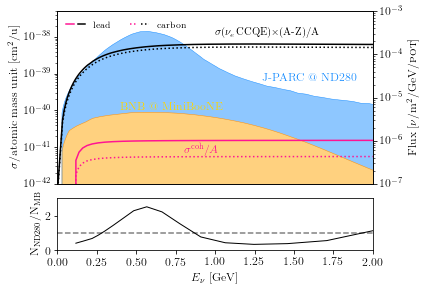

In [14]:
from matplotlib.legend_handler import HandlerTuple

axes_form_upper_panel  = [0.14,0.13+0.23,0.73,0.6]
axes_form_bottom_panel = [0.14,0.13,0.73,0.18]

fig = plt.figure()
ax2 = fig.add_axes(axes_form_upper_panel)
ax = ax2.twinx()
ax2.set_zorder(ax.get_zorder() + 1)
ax2.patch.set_visible(False)


carbon_qe, = ax2.plot(E, sigma_material['carbon']/material_A['carbon'], ls=':', c='deeppink', lw=1.5, zorder=10)
lead_qe, = ax2.plot(E, sigma_material['lead']/material_A['lead'], c='deeppink', lw=1.5, zorder=10)

e_ccqe, sigma_ccqe = np.loadtxt("./digitized/ccqe_cross_sections/quasielastic_electron_neutrino_cross_section.dat", unpack=True)
carbon_coh, = ax2.plot(np.append(0.0,e_ccqe), 
         np.append(1e-4,sigma_ccqe)*1e-38*(material_A['carbon']-material_Z['carbon'])/material_A['carbon'], 
         ls=':', c='black', lw=1.5, label = r'SM $\nu_e$CCQE C')
lead_coh, = ax2.plot(np.append(0.0,e_ccqe), 
         np.append(1e-4,sigma_ccqe)*1e-38*(material_A['lead']-material_Z['lead'])/material_A['lead'],
         c='black', lw=1.5, label = r'SM $\nu_e$CCQE Pb')
    
ax2.legend([(lead_qe, lead_coh), (carbon_qe, carbon_coh)],
             ['lead', 'carbon'],
             frameon=False, 
             # numpoints=4,
             loc='upper left',
             ncol=2,
             handler_map={tuple: HandlerTuple(ndivide=None)})

###########################
# FLUXES
e_int = np.linspace(0.005,3,500)
units = 1e4

###### PLOT MINIBOONE
s2 = ax.fill_between(e_int, np.zeros(np.size(e_int)), MBflux(e_int)*units, lw = 0.5, edgecolor="None", facecolor="orange", alpha=0.5, zorder=-1)
s2 = ax.plot(e_int, MBflux(e_int)*units, lw = 0.5, color="darkorange", zorder=5)
###### PLOT T2K -- ND280
fluxND = NDflux(e_int)*units
s2 = ax.fill_between(e_int, MBflux(e_int)*units, fluxND, lw = 0.0, edgecolor="None", facecolor="dodgerblue", alpha=0.5, zorder=1)
s2 = ax.plot(e_int, fluxND, lw = 0.5, color="dodgerblue", zorder=5)

## labels
ax.set_ylabel(r'Flux [$\nu/{\rm m}^2/{\rm GeV}/{\rm \textsc{pot}}$]')
ax.set_yscale('log')
ax.set_ylim(1e-7,1e-3)
ax.set_xlim(left=0)
ax.xaxis.set_visible(False)

## labels
ax2.set_ylabel(r'$\sigma$/atomic mass unit [cm$^2$/u]')
ax2.set_yscale("log")
ax2.set_ylim(1e-42, 5e-38)
ax2.set_xlim(0.025, EMAX)
ax2.xaxis.set_visible(False)
ax2.set_xlim(left=0)

ax2.annotate(r"{$\sigma$($\nu_e$CCQE)}$\times$(A-Z)/A", fontsize=fsize*0.9, xy=(1, 1.1e-38), rotation=0., color="black", rotation_mode='anchor')
ax2.annotate(r"$\sigma^{\rm coh}/A$", fontsize=fsize, xy=(0.8, 0.7e-41), rotation=0, color="deeppink", rotation_mode='anchor')
# ax2.annotate(r"$\sigma_{\rm Pb}^{\rm coh}/207$", fontsize=fsize, xy=(0.6, 2.5e-41), rotation=0, color="black", rotation_mode='anchor')
# ax2.annotate(r"$\sigma_{\rm C}^{\rm coh}/12$", fontsize=fsize, xy=(0.8, 2e-42), rotation=0, color="black", rotation_mode='anchor')
ax2.annotate(r"BNB @ MiniBooNE", fontsize=fsize, xy=(0.4, 1e-40), rotation=0, color="gold", rotation_mode='anchor')
ax2.annotate(r"J-PARC @ ND280", fontsize=fsize, xy=(1.3, 6e-40), rotation=0, color="dodgerblue", rotation_mode='anchor')

ax3 = fig.add_axes(axes_form_bottom_panel)
ax3.patch.set_visible(False)
ax3.axhline(1, 0, EMAX, color='gray', ls='--')
ax3.plot(E, ratio_events, c='black', lw=1) 
ax3.set_xlim(0, EMAX)
ax3.set_ylim(0.0, 3)
ax3.set_ylabel(r'${\rm N}_{\rm ND280} / {\rm N}_{\rm MB}$')
ax3.set_xlabel(r'$E_\nu$ [GeV]')

plt.savefig(save_folder+'xsec_flux_plot.pdf')
plt.savefig(save_folder+'xsec_flux_plot.png', dpi=500, transparent=True)